In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import paper_classes_2 as pc
import Post_processing as pp

In [2]:
def create_community(inputs):
    
    '''
    Description
    -----------
    Define the houses with PV and Battery
    This function takes the PV and Batt penetration as inputs, reads the df of generation in Munich and the PV_size_distribution, 
    and RANDOMLY (unless we are in mode test or looking at a particular day of summer or winter) chooses the sizes 
    for the X houses (RANDOMLY selected unless in test mode) 

    Parameters
    ------
    inputs: dict; Dictionary that includes PV_penetration,Batt_penetration, resolution (reso),path,day_selection (day_sel)

    Return
    ------
    inputs: dict; Updated dictionary that includes the demand, pv generation, flag of surplus in the community and the houses that include PV and PV+Batt

    TODO
    ------

    '''
    print('################################################')
    print('Creating the community')
    print('%%%%%%%%%%%%%%%%%%%%%%%')
    print('Loading PV combinations')
    df_gen_comb=pd.read_csv(inputs['path']+'Input/DE_gen_15_min_Energy.csv', encoding='utf8', sep=',',engine='python',
                            date_parser=lambda col: pd.to_datetime(col, utc=True),infer_datetime_format=True,index_col=0)
    df_gen_comb.index = df_gen_comb.index.tz_convert('CET')
    print('%%%%%%%%%%%%%%%%%%%%%%%')
    print('Loading demand')
    if inputs['reso']=='1h':
        df_demand=pd.read_csv(inputs['path']+'Input/DE_load_15_min_Power.csv', encoding='utf8', sep=',',
                              engine='python',date_parser=lambda col: pd.to_datetime(col, utc=True),infer_datetime_format=True,index_col=0)/4
        df_demand.index=df_demand.index.tz_convert('CET')
        df_demand=df_demand.resample('1H').sum()
        #df_demand.index = df_demand.index.tz_localize('UTC').tz_convert('CET')
        df_gen_comb=df_gen_comb.resample('1H').sum()
        df_demand.index=df_gen_comb.index
    else:
        df_demand=pd.read_csv(inputs['path']+'Input/DE_load_15_min_Power.csv', encoding='utf8', sep=',',engine='python', 
                              date_parser=lambda col: pd.to_datetime(col, utc=True),infer_datetime_format=True,index_col=0)/4
        df_demand.index=df_demand.index.tz_convert('CET')
        #df_demand.index = df_demand.index.tz_localize('UTC').tz_convert('CET')
        df_demand.index=df_gen_comb.index
    selection_PV=np.random.choice(df_demand.columns,int(np.floor(df_demand.shape[1]*inputs['PV_penetration'])), replace=False)
    selection_PV_Batt=np.random.choice(selection_PV,int(np.floor(df_demand.shape[1]*inputs['PV_penetration']*inputs['Batt_penetration'])), replace=False)

    #We decide among the whole community which houses will have PV and PV and Batt

    if inputs['day_sel'] in ['winter','summer','test']:
        selection_PV=['41','24','65','0','69','8','49','63','2','1','14','42','67','10','6','9','38','50']
        selection_PV_Batt=['69','41','10','63','50','9','0','49','38','67','1','2','42','24','8','65','6','14']
    # We have to define the prices for the community based on PV penetration. We can include some variation in azimuth and angle but in general, I guess, only three or four should be ok. The df loaded has 66 combinations.

    # As an example I will take the 66 PV profiles for different azimuths and inclinations, but this input data must be modified once we define the final community

    # The PV size for every house must be defined. If the household have a Battery the PV size comes from another distribution
    print('%%%%%%%%%%%%%%%%%%%%%%%')
    print('Creating distributions')
    PV_sizes=pd.read_csv(inputs['path']+'Input/PV_size_distribution.csv',index_col=0,header=None)
    PV_sizes_batt=pd.read_csv(inputs['path']+'Input/PV_size_distribution.csv',index_col=0,header=None)#change this input for the real distribution of PV+battery
    #The output of this function: should be a combined df with
    #df_prices,df_generation,df_demand
    count_batt, division_batt = np.histogram(PV_sizes_batt)
    prob_size_batt=count_batt/PV_sizes_batt.size
    possible_sizes=np.arange(1,11)#for residential we consider from 1 to 10
    amount_PV_batt_systems=int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*74))
    sizes_PV_batt=np.random.choice(possible_sizes,amount_PV_batt_systems, p=prob_size_batt)
    #Delete after tests
    if inputs['day_sel'] in ['winter','summer','test']:
        sizes_PV_batt=[7,7,6,4,10,9,5,6,5,8,6,7,5,10,9,3,5,7]
        
    # Select the PV profiles randomly and include the size in the name of the columns
    newcols_batt=[]
    #We select from all the combinations of azimuth and inclination randomly
    selection_batt=np.random.choice(df_gen_comb.columns,int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*74)))
    count, division = np.histogram(PV_sizes)
    prob_size=count/PV_sizes.size
    amount_PV_systems=int(np.floor(inputs['PV_penetration']*74))
    sizes=np.random.choice(possible_sizes,amount_PV_systems, p=prob_size)
    if inputs['day_sel'] in ['winter','summer','test']:
        sizes=[3,3,9,10,9,6,4,10,3,7,5,10,6,4,10,10,5,9]
        selection_batt=['PV_-50_35','PV_-10_20','PV_30_40','PV_50_35','PV_40_40','PV_-40_45','PV_10_45','PV_-50_30','PV_-30_35','PV_10_20','PV_20_30','PV_-50_45','PV_30_25','PV_10_40','PV_-50_30','PV_-50_25','PV_50_35','PV_10_25']
  # Select the PV profiles randomly and include the size in the name of the columns
    newcols=[]
    #We select from all the combinations of azimuth and inclination randomly

    selection=np.random.choice(df_gen_comb.columns,len(selection_PV)-len(selection_batt))
    print('%%%%%%%%%%%%%%%%%%%%%%%')
    print('Assingning PV to households')
    j=0
    k=0
    m=0
    df_sel=pd.DataFrame()
    df_sel_batt=pd.DataFrame()
    df_residual_load=pd.DataFrame()
    for i in df_demand.columns:
        if i in selection_PV_Batt:
            if j==0:
                df_sel_batt=df_gen_comb[selection_batt[j]]*sizes_PV_batt[j]
            else:
                df_sel_batt=pd.concat([df_sel_batt, df_gen_comb[selection_batt[j]]*sizes_PV_batt[j]], axis=1, join='inner')
            if m==0:
                df_residual_load=df_demand.loc[:,i]-df_gen_comb[selection_batt[j]]*sizes_PV_batt[j]
            else:
                df_residual_load=pd.concat([df_residual_load, df_demand.loc[:,i]-df_gen_comb[selection_batt[j]]*sizes_PV_batt[j]], axis=1, join='inner')
            newcols_batt.append('hh_'+str(i)+'_'+selection_batt[j]+'_size_'+str(sizes_PV_batt[j]))

            j+=1
        elif i in selection_PV:

            if k==0:
                df_sel=df_gen_comb[selection[k]]*sizes[k]
            else:
                df_sel=pd.concat([df_sel, df_gen_comb[selection[k]]*sizes[k]], axis=1, join='inner')
            if m==0:
                df_residual_load=df_demand.loc[:,i]-df_gen_comb[selection[k]]*sizes[k]
            else:
                df_residual_load=pd.concat([df_residual_load, df_demand.loc[:,i]-df_gen_comb[selection[k]]*sizes[k]], axis=1, join='inner')
            newcols.append('hh_'+str(i)+'_'+selection[k]+'_size_'+str(sizes[k]))

            k+=1
        else:
            if m==0:
                df_residual_load=df_demand.loc[:,i]
            else:
                df_residual_load=pd.concat([df_residual_load, df_demand.loc[:,i]], axis=1, join='inner')
        m+=1

    df_sel.columns=newcols
    df_sel_batt.columns=newcols_batt
    if inputs['Batt_penetration']==1:
        df_sel=df_sel_batt
    else:
        if df_sel.shape[0]==0:
            print('bla')
            df_sel=df_sel_batt.copy()
        else:
            df_sel=pd.concat([df_sel, df_sel_batt], axis=1, join='inner')
    df_residual_load.columns=df_demand.columns
    #The matching from PV-demand is done first.
    flag_surplus_community=df_residual_load.sum(axis=1)
    flag_surplus_community[flag_surplus_community>0]=0
    flag_surplus_community[flag_surplus_community<0]=1
    inputs.update({'df_demand':df_demand,'df_generation':df_sel,'selection_PV':selection_PV,'selection_PV_Batt':selection_PV_Batt,'flag':flag_surplus_community})
    print('%%%%%%%%%%%%%%%%%%%%%%%')
    print('Finished')
    return inputs



In [3]:

def find_interval_PQ(x, partition):
    '''
    Description
    -----------
    find_interval at which x belongs inside partition. Returns the index i.

    Parameters
    ------
    x: float; numerical value
    partition: array; sequence of numerical values
    Returns
    ------
    i: index; index for which applies
    partition[i] < x < partition[i+1], if such an index exists.
    -1 otherwise
    TODO
    ------
    '''
    
    for i in range(0, len(partition)):
        #print(partition)
        if x<partition[1]:
            return 1
        elif x < partition[i]:
            return i-1
        
    return -1

In [4]:

def find_interval(x, partition):
    '''
    Description
    -----------
    find_interval at which x belongs inside partition. Returns the index i.

    Parameters
    ------
    x: float; numerical value
    partition: array; sequence of numerical values
    Returns
    ------
    i: index; index for which applies
    partition[i] < x < partition[i+1], if such an index exists.
    -1 otherwise
    TODO
    ------
    '''

    for i in range(0, len(partition)):
        if x < partition[i]:
            return i-1
    return -1

In [84]:
def price_probability(inputs):
    '''
    Description
    -----------
    Define the price structure according to the inputs (how the community is created), the choice of the probability, 
    whether it is for the 50% or other probability according to the psychology data, the amount of kWh that will be 
    discharged every time a decision is made (1 or 2 kWh are the "normal" options) and the case, whether it is the
    price created from the probability of selling from PV or the battery in the morning or the evening.
    
    Parameters
    ------
    inputs:        dict; Dictionary that includes prob_choice (choice of the probability to create the prices 50% or other),
                    prices, kWh_dis (amount of energy to be discharged at every time a decision is made),  
                    case (included in ['PV', 'Batt'] the price may be created from the probability of selling from PV or the battery

    Return
    ------
    inputs: dict; Input dictionary updated with prices

    TODO
    ------

    '''
    net_demand=inputs['df_demand'].sum(axis=1)-inputs['df_generation'].sum(axis=1)
    prob_mat_PV=pd.read_csv(inputs['path']+'Input/P_selling_by_price_and_autarky2.txt',sep='\t',index_col=[0])
    prob_mat_Batt=pd.read_csv(inputs['path']+'Input/P_selling_by_price_and_autarky_2.txt',sep='\t',index_col=[0])
    if len(inputs['prob_choice'])==1:
        q_supply_midday=int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*inputs['df_demand'].shape[1]))*prob_mat_PV.loc[inputs['prob_choice'][0],:]*inputs['kWh_dis']
        q_supply_other=int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*inputs['df_demand'].shape[1]))*prob_mat_Batt.loc[inputs['prob_choice'][0],:]*inputs['kWh_dis']
        print(q_supply_other)
        df_prices=pd.DataFrame(index=net_demand.index)
        df_prices.loc[:,'prices']=net_demand.apply(lambda x:inputs['prices'][find_interval_PQ(x,q_supply_midday)])
        df_prices.loc[(df_prices.index.hour<10)|(df_prices.index.hour>17),'prices']=net_demand[(net_demand.index.hour<10)|(net_demand.index.hour>17)].apply(lambda x:inputs['prices'][find_interval_PQ(x,q_supply_other)])
        inputs.update({'df_prices':df_prices})
        return inputs
    elif len(inputs['prob_choice'])==3:
        q_supply_morning=int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*inputs['df_demand'].shape[1]))*prob_mat_Batt.loc[inputs['prob_choice'][0],:]*inputs['kWh_dis']
        q_supply_midday=int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*inputs['df_demand'].shape[1]))*prob_mat_PV.loc[inputs['prob_choice'][1],:]*inputs['kWh_dis']
        q_supply_evening=int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*inputs['df_demand'].shape[1]))*prob_mat_Batt.loc[inputs['prob_choice'][2],:]*inputs['kWh_dis']
        print(q_supply_evening)
        df_prices=pd.DataFrame(index=net_demand.index)
        df_prices.loc[:,'prices']=net_demand.apply(lambda x:inputs['prices'][find_interval_PQ(x,q_supply_midday)])
        df_prices.loc[df_prices.index.hour<10,'prices']=net_demand[net_demand.index.hour<10].apply(lambda x:inputs['prices'][find_interval_PQ(x,q_supply_morning)])
        df_prices.loc[df_prices.index.hour>17,'prices']=net_demand[net_demand.index.hour>17].apply(lambda x:inputs['prices'][find_interval_PQ(x,q_supply_evening)])

        inputs.update({'df_prices':df_prices})
        return inputs
    else:
        print('Warning: this function only takes either one choice of probability for the whole day or three separated for morning, midday and evening')
        return

    

In [45]:

def sell_prob(SOC,price,Capacity,case,path):
    '''
    Description
    -----------
    This function returns the selling probability based on the SOC, price, capacity and case. As well as the results of the survey which are stored as .txt
    Parameters
    ------
    SOC: float; Battery state of charge at time t
    price: float; Electricity price at time t
    Capacity: float; Battery capacity
    case: string; either PV or batt from where the user is willing to sale
    path: string; path where the .txt are found
    ------
    out: int; Either 1 or 0 if sell or not
    TODO
    ------
    '''
    #define the matrix of probs
    if case=='PV':
        prob_mat=pd.read_table(path+'Input/P_selling_by_price_and_autarky2.txt',sep='\t',index_col=[0])
        #prob_mat=pd.read_table(path+'Input/surplus_cluster1_p_selling.txt',sep='\t',index_col=[0])
        #prob_mat=pd.read_table(path+'Input/surplus_cluster2_p_selling.txt',sep='\t',index_col=[0])
    else:#when selling from battery
        prob_mat=pd.read_table(path+'Input/P_selling_by_price_and_autarky_2.txt',sep='\t',index_col=[0])
        #prob_mat=pd.read_table(path+'Input/nosurplus_cluster1_p_selling.txt',sep='\t',index_col=[0])
        #prob_mat=pd.read_table(path+'Input/nosurplus_cluster2_p_selling.txt',sep='\t',index_col=[0])
    if SOC==0:
        out=0
    else:
        I=np.array([0,0.05,0.2,0.35,0.5,0.65,0.8,0.95,1.0001])#define the interval of SOC
        ind=find_interval(SOC,I*Capacity)
        if ind==-1:
            prob=prob_mat.loc[1,str(price)]
        else:
            prob=prob_mat.loc[I[ind],str(price)]
        out=np.random.choice(2,1,p=[1-prob,prob])
    return out


In [46]:

def PV_SC(df,Batt,Conv_eff,Inv_eff,endo):
    '''
    Description
    -----------
    This function calculates the energy flows of each house WHITHOUT consumer behaviour.

    Parameters
    ------
    df: DataFrame;
    Batt: Battery class; Battery characteristics
    Conv_eff: float; Converter efficiency
    Inv_eff: float; Inverter efficiency
    endo: int; Defines the last element of the index we want to simulate

    ------
    df: DataFrame; with energy flows for each house
    TODO
    ------

    '''
    for i in range(len(df.index[:endo])):
        if df.gen[i]<df.demand[i]/Conv_eff/Inv_eff:#No surplus including losses
            if i==0:#CI
                df.grid_load[i]=df.demand[i]-df.gen[i]*Conv_eff*Inv_eff
            else:
                if df.SOC[i-1]>Batt.SOC_min:#Discharge battery to the load
                    df.E_dis[i]=min(df.SOC[i-1]-Batt.SOC_min,
                                        (df.demand[i]-df.gen[i]*Conv_eff*Inv_eff)/Inv_eff)
                    df.Batt_load[i]=df.E_dis[i]*Inv_eff#after inverter
                    df.SOC[i]=df.SOC[i-1]-df.E_dis[i]
                    df.Batt_losses[i]=df.E_dis[i]*(1-Inv_eff)#+inherent to the batt (eff)
                    df.PV_load[i]=df.gen[i]*Conv_eff*Inv_eff#after inverter
                    df.PV_losses[i]=df.gen[i]*(1-Conv_eff*Inv_eff)
                    df.grid_load[i]=df.demand[i]-df.PV_load[i]-df.Batt_load[i]

                else:#Use energy from the grid
                    df.E_dis[i]=0
                    df.Batt_load[i]=df.E_dis[i]*Inv_eff
                    df.grid_load[i]=df.demand[i]-df.gen[i]*Conv_eff*Inv_eff#-df.Batt_load[i], is zero
                    df.PV_load[i]=df.gen[i]*Conv_eff*Inv_eff
                    df.SOC[i]=df.SOC[i-1]
                    df.PV_losses[i]=df.gen[i]*(1-Conv_eff*Inv_eff)
        else:#Surplus
            #include here the probability function
            if i==0:#CI
                df.grid_load[i]=df.demand[i]
            else:
                df.PV_load[i]=df.demand[i]#First, cover local demand (after inverter)
                if df.SOC[i-1]<Batt.SOC_max:#then if battery not full, charge
                    df.PV_batt[i]=min((df.gen[i]*Conv_eff-df.demand[i]/Inv_eff),
                                      (Batt.SOC_max-df.SOC[i-1])*Conv_eff)
                    df.SOC[i]=df.SOC[i-1]+df.PV_batt[i]*Batt.Efficiency
                    df.Batt_losses[i]=df.PV_batt[i]*(1-Batt.Efficiency)

                    df.PV_grid[i]=(df.gen[i]*Conv_eff-df.PV_batt[i])*Inv_eff-df.PV_load[i]
                    df.grid_load[i]=0
                else:#otherwise, export to the grid
                    df.PV_batt[i]=0
                    df.PV_grid[i]=df.gen[i]*Conv_eff*Inv_eff-df.PV_load[i]
                    df.SOC[i]=df.SOC[i-1]
                    df.grid_load[i]=0
                df.PV_losses[i]=df.gen[i]-df.PV_grid[i]-df.PV_batt[i]-df.PV_load[i]
    return df


In [77]:
PV_penetration=0.5
reso='1h'
path='./'
day_sel='winter'
if (day_sel=='winter') or (day_sel=='summer'):
    endo=96
else:
    endo=8760
Conv_eff=0.98
Inv_eff=0.95
prices=np.array([0, 0.07,.10,.13,.16,.19,.22,.25,.28])
kWh_dis=1
case='PV'
prob_choice=[0.35,0.5,0.95]
Batt=pc.Battery(10,'NMC')


In [78]:
Batt_penetration=1.

inputs={'Conv_eff':Conv_eff, 'Inv_eff':Inv_eff,'prices':prices,'Batt':Batt,'PV_penetration':PV_penetration,
                   'Batt_penetration':Batt_penetration,'prob_choice':prob_choice,'kWh_dis':kWh_dis,'case':case,'reso':reso,'path':path,'day_sel':day_sel}

In [79]:
inputs=create_community(inputs)


################################################
Creating the community
%%%%%%%%%%%%%%%%%%%%%%%
Loading PV combinations
%%%%%%%%%%%%%%%%%%%%%%%
Loading demand
%%%%%%%%%%%%%%%%%%%%%%%
Creating distributions
%%%%%%%%%%%%%%%%%%%%%%%
Assingning PV to households
%%%%%%%%%%%%%%%%%%%%%%%
Finished


In [85]:
inputs=price_probability(inputs)

0.07    4.32
0.1     5.13
0.13    7.83
0.16    8.46
0.19    8.73
0.22    8.82
0.25    8.64
0.28    8.91
Name: 0.95, dtype: float64


In [89]:
p=[]
qs=[]
for i in range(4):
    Batt_penetration=.25*(i+1)

    inputs={'Conv_eff':Conv_eff, 'Inv_eff':Inv_eff,'prices':prices,'Batt':Batt,'PV_penetration':PV_penetration,
                   'Batt_penetration':Batt_penetration,'prob_choice':prob_choice,'kWh_dis':kWh_dis,'case':case,'reso':reso,'path':path,'day_sel':day_sel}
    inputs=create_community(inputs)
    inputs=price_probability(inputs)
    #inputs=Price_definition(prices,PV_penetration,Batt_penetration,reso,path,day_sel)

    system_param={'Batt':Batt,'Conv_eff':Conv_eff,'Inv_eff':Inv_eff,'endo':endo,'day_sel':day_sel,'path':path}

    print('################################################')
    print('Simulation begins')
    #inputs['df_prices'].groupby(inputs['df_prices'].index.hour).mean().plot()
    p.append(inputs['df_prices'].groupby(inputs['df_prices'].index.hour).mean().values)
    #qs.append(inputs['q_supply'].values)
#pd.DataFrame(np.array(p).reshape(3,24).T).plot()
print('################################################')
print('Simulation ends')

################################################
Creating the community
%%%%%%%%%%%%%%%%%%%%%%%
Loading PV combinations
%%%%%%%%%%%%%%%%%%%%%%%
Loading demand
%%%%%%%%%%%%%%%%%%%%%%%
Creating distributions
%%%%%%%%%%%%%%%%%%%%%%%
Assingning PV to households
bla
%%%%%%%%%%%%%%%%%%%%%%%
Finished
0.07    4.32
0.1     5.13
0.13    7.83
0.16    8.46
0.19    8.73
0.22    8.82
0.25    8.64
0.28    8.91
Name: 0.95, dtype: float64
################################################
Simulation begins
################################################
Creating the community
%%%%%%%%%%%%%%%%%%%%%%%
Loading PV combinations
%%%%%%%%%%%%%%%%%%%%%%%
Loading demand
%%%%%%%%%%%%%%%%%%%%%%%
Creating distributions
%%%%%%%%%%%%%%%%%%%%%%%
Assingning PV to households
bla
%%%%%%%%%%%%%%%%%%%%%%%
Finished
0.07     8.64
0.1     10.26
0.13    15.66
0.16    16.92
0.19    17.46
0.22    17.64
0.25    17.28
0.28    17.82
Name: 0.95, dtype: float64
################################################
Simulation begins
######

In [90]:
inputs['df_prices'].groupby(inputs['df_prices'].index.hour).mean().values.flatten()

array([0.27712329, 0.24868493, 0.20052055, 0.18342466, 0.18884932,
       0.20726027, 0.23438356, 0.23578082, 0.19986301, 0.15712329,
       0.12063014, 0.10246575, 0.09589041, 0.09630137, 0.10016438,
       0.11808219, 0.16024658, 0.19123288, 0.18441096, 0.22780822,
       0.2710411 , 0.27934247, 0.27967123, 0.23890411])

<Figure size 720x720 with 0 Axes>

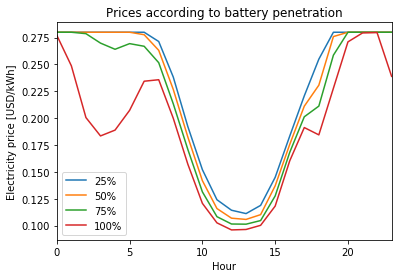

In [91]:
plt.figure(figsize=(10,10))

pd.DataFrame(np.array(p).reshape(4,24).T,columns=['25%','50%','75%','100%']).plot()
plt.title('Prices according to battery penetration')
plt.xlabel('Hour')
plt.ylabel('Electricity price [USD/kWh]')
plt.savefig('prices.png')

In [58]:
nd=inputs['df_demand'].sum(axis=1)-inputs['df_generation'].sum(axis=1)

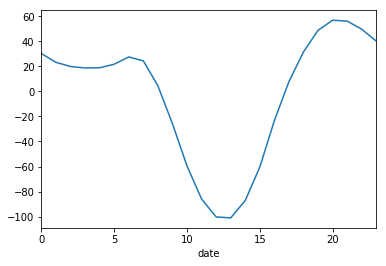

In [59]:
nd.groupby(nd.index.hour).mean().plot()

In [60]:
qs

[array([0.5957  , 0.635475, 1.8463  , 2.85825 , 3.691675, 4.644425,
        5.63695 , 5.79605 ]),
 array([ 1.1914 ,  1.27095,  3.6926 ,  5.7165 ,  7.38335,  9.28885,
        11.2739 , 11.5921 ]),
 array([ 1.7871  ,  1.906425,  5.5389  ,  8.57475 , 11.075025, 13.933275,
        16.91085 , 17.38815 ]),
 array([ 2.3828,  2.5419,  7.3852, 11.433 , 14.7667, 18.5777, 22.5478,
        23.1842])]

In [61]:
prices

array([0.  , 0.07, 0.1 , 0.13, 0.16, 0.19, 0.22, 0.25, 0.28])

In [62]:
np.array(qs).reshape(4,8).T

array([[ 0.5957  ,  1.1914  ,  1.7871  ,  2.3828  ],
       [ 0.635475,  1.27095 ,  1.906425,  2.5419  ],
       [ 1.8463  ,  3.6926  ,  5.5389  ,  7.3852  ],
       [ 2.85825 ,  5.7165  ,  8.57475 , 11.433   ],
       [ 3.691675,  7.38335 , 11.075025, 14.7667  ],
       [ 4.644425,  9.28885 , 13.933275, 18.5777  ],
       [ 5.63695 , 11.2739  , 16.91085 , 22.5478  ],
       [ 5.79605 , 11.5921  , 17.38815 , 23.1842  ]])

In [63]:
pd.DataFrame(np.array(qs).reshape(4,8).T,index=prices[1:]).T

,0.07,0.1,0.13,0.16,0.19,0.22,0.25,0.28
0,0.5957,0.635475,1.8463,2.85825,3.691675,4.644425,5.63695,5.79605
1,1.1914,1.270950,3.6926,5.71650,7.383350,9.288850,11.27390,11.59210
2,1.7871,1.906425,5.5389,8.57475,11.075025,13.933275,16.91085,17.38815
3,2.3828,2.541900,7.3852,11.43300,14.766700,18.577700,22.54780,23.18420


In [64]:
qs

[array([0.5957  , 0.635475, 1.8463  , 2.85825 , 3.691675, 4.644425,
        5.63695 , 5.79605 ]),
 array([ 1.1914 ,  1.27095,  3.6926 ,  5.7165 ,  7.38335,  9.28885,
        11.2739 , 11.5921 ]),
 array([ 1.7871  ,  1.906425,  5.5389  ,  8.57475 , 11.075025, 13.933275,
        16.91085 , 17.38815 ]),
 array([ 2.3828,  2.5419,  7.3852, 11.433 , 14.7667, 18.5777, 22.5478,
        23.1842])]

In [65]:
np.insert(np.array(qs).reshape(4,8).T,0,values=[0,0,0,0],axis=0)

array([[ 0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.5957  ,  1.1914  ,  1.7871  ,  2.3828  ],
       [ 0.635475,  1.27095 ,  1.906425,  2.5419  ],
       [ 1.8463  ,  3.6926  ,  5.5389  ,  7.3852  ],
       [ 2.85825 ,  5.7165  ,  8.57475 , 11.433   ],
       [ 3.691675,  7.38335 , 11.075025, 14.7667  ],
       [ 4.644425,  9.28885 , 13.933275, 18.5777  ],
       [ 5.63695 , 11.2739  , 16.91085 , 22.5478  ],
       [ 5.79605 , 11.5921  , 17.38815 , 23.1842  ]])

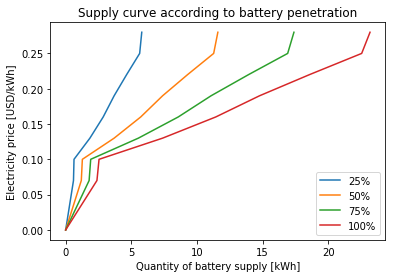

In [66]:
plt.plot(np.insert(np.array(qs).reshape(4,8).T,0,values=[0,0,0,0],axis=0),prices)
labels=['25%','50%','75%','100%']
plt.legend(labels)
plt.xlabel('Quantity of battery supply [kWh]')
plt.ylabel('Electricity price [USD/kWh]')
plt.title('Supply curve according to battery penetration')
plt.savefig('QP.png')

In [36]:
nd[1]

38.45785

In [37]:
pd.DataFrame(np.array(nd).reshape(4,24).T,columns=['0.25','0.5','0.75','1.0']).plot()

ValueError: cannot reshape array of size 8760 into shape (4,24)

In [431]:
#p=[]
p.append(inputs['df_prices'].groupby(inputs['df_prices'].index.hour).mean().values)


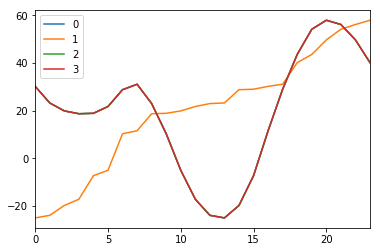

In [472]:
pd.DataFrame(np.array(nd).reshape(4,24).T).plot()

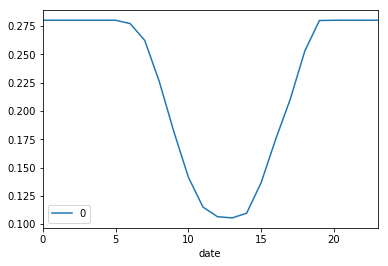

In [376]:
inputs['df_prices'].groupby(inputs['df_prices'].index.hour).mean().plot()

In [295]:
df_no_comm=no_community_approach(inputs,system_param)

################################################
Simulating without community exchange
demand           346695.14
gen              175392.31
SOC                3580.37
PV_batt             260.73
PV_load             232.84
PV_grid              96.70
E_dis               328.31
Batt_load           311.89
Batt_grid             0.00
grid_load        265316.87
PV_losses            29.74
Batt_losses          37.80
flag                  0.00
type             315360.00
df             23660760.00
prices           145312.32
dtype: float64
End of simulation without community exchange
###################################################
################################################
Simulation with community exchange


In [297]:
7900/346695*100

2.278659917218304

In [418]:
Batt_penetration=1.0
probs_applied=3

df_no_comm=pd.read_csv(path+'Output/no_community_{}_{}_{}.csv'.format(PV_penetration,Batt_penetration,probs_applied),encoding='utf8', sep=',',header=0,
    engine='python',date_parser=lambda col: pd.to_datetime(col, utc=True), parse_dates=[1],infer_datetime_format=True,index_col=0,
names=['index','date','demand','gen','SOC','PV_batt', 'PV_load', 'PV_grid', 'E_dis','Batt_load','Batt_grid','grid_load','PV_losses','Batt_losses','flag','type','df','prices'])
df_no_comm.loc[:,'date'] =pd.DatetimeIndex(df_no_comm.loc[:,'date']).tz_convert('CET')
#df_no_comm.loc[:,'date'].dt.hour

df_comm=pd.read_csv(path+'Output/community_{}_{}_{}.csv'.format(PV_penetration,Batt_penetration,probs_applied),encoding='utf8', sep=',',header=0,
    engine='python',date_parser=lambda col: pd.to_datetime(col, utc=True), parse_dates=[1],infer_datetime_format=True,index_col=0,
                    names=['index','date','demand','gen','SOC','PV_batt', 'PV_load', 'PV_comm', 'E_dis','Batt_load','Batt_comm','comm_load','PV_losses','Batt_losses','flag','type','df','prices'])

df_comm.loc[:,'date'] =pd.DatetimeIndex(df_comm.loc[:,'date']).tz_convert('CET')


In [411]:
df_comm.loc[:,['Batt_comm']].sum()/df_comm.loc[:,['demand']].sum().values*100

Batt_comm    6.114168
dtype: float64

In [531]:

df_comm[df_comm.flag==4].loc[:,['PV_comm']].max()

PV_comm    0.948342
dtype: float64

In [532]:
df

[]

In [419]:
df_comm.pivot_table(columns='flag',index='date',aggfunc='size').sum()

flag
0.0    595213.0
1.0     46763.0
2.0      3934.0
3.0       208.0
4.0      2122.0
dtype: float64

In [560]:
import Psycho_paper_community as ppc
import paper_classes_2 as pp

In [561]:
df1=df_comm[df_comm.df==0].loc[:,['date','demand','gen','prices']]

In [562]:
df1.head()

,date,demand,gen,prices
index,,,,
0,2015-01-01 00:00:00+01:00,0.143233,0.0,0.28
1,2015-01-01 01:00:00+01:00,0.173217,0.0,0.28
2,2015-01-01 02:00:00+01:00,0.146900,0.0,0.28
3,2015-01-01 03:00:00+01:00,0.162667,0.0,0.28
4,2015-01-01 04:00:00+01:00,0.162200,0.0,0.28


In [563]:
df1 = df1.reindex( columns = df1.columns.tolist() + ['SOC','PV_batt', 'PV_load', 'PV_grid', 'E_dis','Batt_load','Batt_grid','grid_load','PV_losses','Batt_losses','flag','type','df']) 

In [564]:
df1.fillna(0, inplace=True)

In [565]:
Batt=pp.Battery(Capacity=10,choicetype='LFP')

In [579]:

df1 = df1.reindex( columns = df1.columns.tolist() + ['SOC','PV_batt', 'PV_load', 'PV_grid', 'E_dis','Batt_load','Batt_grid','grid_load','PV_losses','Batt_losses','flag','type','df']) 
df1.fillna(0, inplace=True)
out_df=ppc.PV_SC(df1[:24],Batt=Batt,Conv_eff=0.8,Inv_eff=0.9,endo=24)

/data/home/alejandropena/Psychology/Psycho_paper_community.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.grid_load[i]=df.demand[i]-df.gen[i]*Conv_eff*Inv_eff
/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/data/home/alejandropena/Psychology/Psycho_paper_community.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.E_dis[i]=0
/data/home/alejandropena/Psychology/Psycho_paper_community.py:158: SettingWith

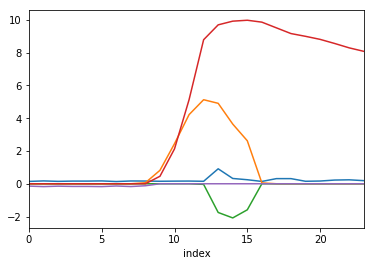

In [580]:
out_df.demand.plot()
out_df.gen.plot()
(-out_df.PV_grid).plot()
out_df.SOC.plot()
(-out_df.grid_load).plot()


In [581]:
out_df.sum()

demand           5.289367
gen             23.909665
prices           5.310000
SOC            117.429680
PV_batt         10.618708
PV_load          2.193277
PV_grid          5.464845
E_dis            1.897534
Batt_load        1.707780
Batt_grid        0.000000
grid_load        1.388309
PV_losses        5.632835
Batt_losses      0.826876
flag             0.000000
type             0.000000
df               0.000000
dtype: float64

In [582]:
out_df.demand-out_df.PV_load-out_df.Batt_load-out_df.grid_load

index
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
dtype: float64

In [583]:
out_df

,date,demand,gen,prices,SOC,PV_batt,PV_load,PV_grid,E_dis,Batt_load,Batt_grid,grid_load,PV_losses,Batt_losses,flag,type,df
index,,,,,,,,,,,,,,,,,
0,2015-01-01 00:00:00+01:00,0.143233,0.000000,0.28,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.143233,0.000000,0.000000,0.0,0.0,0.0
1,2015-01-01 01:00:00+01:00,0.173217,0.000000,0.28,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.173217,0.000000,0.000000,0.0,0.0,0.0
2,2015-01-01 02:00:00+01:00,0.146900,0.000000,0.28,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.146900,0.000000,0.000000,0.0,0.0,0.0
3,2015-01-01 03:00:00+01:00,0.162667,0.000000,0.28,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.162667,0.000000,0.000000,0.0,0.0,0.0
4,2015-01-01 04:00:00+01:00,0.162200,0.000000,0.28,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.162200,0.000000,0.000000,0.0,0.0,0.0
5,2015-01-01 05:00:00+01:00,0.173000,0.000000,0.28,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.173000,0.000000,0.000000,0.0,0.0,0.0
6,2015-01-01 06:00:00+01:00,0.136000,0.000000,0.28,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.136000,0.000000,0.000000,0.0,0.0,0.0
7,2015-01-01 07:00:00+01:00,0.169467,0.000000,0.28,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.169467,0.000000,0.000000,0.0,0.0,0.0
8,2015-01-01 08:00:00+01:00,0.166233,0.061955,0.28,0.000000,0.000000,0.044607,0.000000e+00,0.000000,0.000000,0.0,0.121626,0.017347,0.000000,0.0,0.0,0.0


In [584]:
out_df.sum()

demand           5.289367
gen             23.909665
prices           5.310000
SOC            117.429680
PV_batt         10.618708
PV_load          2.193277
PV_grid          5.464845
E_dis            1.897534
Batt_load        1.707780
Batt_grid        0.000000
grid_load        1.388309
PV_losses        5.632835
Batt_losses      0.826876
flag             0.000000
type             0.000000
df               0.000000
dtype: float64

In [121]:
df_100=pp.Post_processing(1.00,.50,0,'./',3)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Energy Balance:
Demand Balance:
4.831690603168681e-13
Generation Balance:
-9.018518964906775e-13
Battery Balance:
0.7607062619064209
                              demand  gen       SOC  PV_batt  PV_load  \
date                                                                    
2015-12-31 19:00:00+01:00  65.535350  0.0  2.606195      0.0      0.0   
2015-12-31 20:00:00+01:00  53.980550  0.0  1.790914      0.0      0.0   
2015-12-31 21:00:00+01:00  50.570267  0.0  1.190651      0.0      0.0   
2015-12-31 22:00:00+01:00  44.928250  0.0  0.900145      0.0      0.0   
2015-12-31 23:00:00+01:00  40.166367  0.0  0.760706      0.0      0.0   

                           PV_comm     E_dis  Batt_load  Batt_comm  comm_load  \
date                                                                            
2015-12-31 19:00:00+01:00      0.0  1.096357   1.041539        0.0  64.493811   
2015-12-31 20:00:00+01:00      0.0  0.815281   0.774517        0.

In [155]:
df_25=pp.Post_processing(.25,.50,0,'./',3)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Energy Balance:
Demand Balance:
1.341149413747189e-13
Generation Balance:
1.0758445925214825e-12
Battery Balance:
-1.0658141036401503e-12
                              demand  gen  SOC  PV_batt  PV_load  PV_comm  \
date                                                                        
2015-12-31 19:00:00+01:00  65.535350  0.0  0.0      0.0      0.0      0.0   
2015-12-31 20:00:00+01:00  53.980550  0.0  0.0      0.0      0.0      0.0   
2015-12-31 21:00:00+01:00  50.570267  0.0  0.0      0.0      0.0      0.0   
2015-12-31 22:00:00+01:00  44.928250  0.0  0.0      0.0      0.0      0.0   
2015-12-31 23:00:00+01:00  40.166367  0.0  0.0      0.0      0.0      0.0   

                           E_dis  Batt_load  Batt_comm  comm_load  ...  \
date                                                               ...   
2015-12-31 19:00:00+01:00    0.0        0.0        0.0  65.535350  ...   
2015-12-31 20:00:00+01:00    0.0        0.0        0.

In [123]:
df_25.groupby(df_25.types).mean()

,bill_comm,bill
types,,
0.0,952.405344,952.405344
8760.0,189.174993,189.174993
17520.0,-188.010600,-41.181024


In [124]:
df_25.groupby(df_25.types).median()

,bill_comm,bill
types,,
0.0,951.331135,951.331135
8760.0,229.223240,229.223240
17520.0,-53.582825,65.325549


In [125]:
df_100.groupby(df_100.types).mean()

,bill_comm,bill
types,,
0.0,506.600566,506.600566
17520.0,-238.090140,-187.535705


In [126]:
df_100.groupby(df_100.types).median()

,bill_comm,bill
types,,
0.0,494.693615,494.693615
17520.0,-227.820238,-177.413018


In [143]:
df_25.groupby(df_25.types).median().pct_change(axis=1)

,bill_comm,bill
types,,
0.0,NaN,0.000000
8760.0,NaN,0.000000
17520.0,NaN,-2.219151


In [141]:
df_25.groupby(df_25.types).mean().pct_change(axis=1)

,bill_comm,bill
types,,
0.0,NaN,0.000000
8760.0,NaN,0.000000
17520.0,NaN,-0.780964


In [144]:
df_100.groupby(df_100.types).median().pct_change(axis=1)

,bill_comm,bill
types,,
0.0,NaN,0.000000
17520.0,NaN,-0.221259


In [142]:
df_100.groupby(df_100.types).mean().pct_change(axis=1)

,bill_comm,bill
types,,
0.0,NaN,0.000000
17520.0,NaN,-0.212333


In [113]:
df_2.groupby(df_2.types).median()

,bill_comm,bill
types,,
0.0,951.331135,951.331135
8760.0,229.223240,229.223240
17520.0,-53.582825,65.325549


In [167]:
columnsTitles=["types","bill","bill_comm"]
df_25=df_25.reindex(columns=columnsTitles)
df_100=df_100.reindex(columns=columnsTitles)


In [168]:
df_25.groupby(df_25.types).median()

,bill,bill_comm
types,,
0.0,951.331135,951.331135
8760.0,229.223240,229.223240
17520.0,65.325549,-53.582825


In [169]:
df_25.groupby(df_25.types).mean()

,bill,bill_comm
types,,
0.0,952.405344,952.405344
8760.0,189.174993,189.174993
17520.0,-41.181024,-188.010600


In [170]:
df_100.groupby(df_100.types).median()

,bill,bill_comm
types,,
0.0,494.693615,494.693615
17520.0,-177.413018,-227.820238


In [171]:
df_100.groupby(df_100.types).mean()

,bill,bill_comm
types,,
0.0,506.600566,506.600566
17520.0,-187.535705,-238.090140


In [172]:
df_25.groupby(df_25.types).median().pct_change(axis=1)

,bill,bill_comm
types,,
0.0,NaN,0.000000
8760.0,NaN,0.000000
17520.0,NaN,-1.820243


In [173]:
df_25.groupby(df_25.types).mean().pct_change(axis=1)

,bill,bill_comm
types,,
0.0,NaN,0.000000
8760.0,NaN,0.000000
17520.0,NaN,3.565467


In [174]:
df_100.groupby(df_100.types).median().pct_change(axis=1)

,bill,bill_comm
types,,
0.0,NaN,0.000000
17520.0,NaN,0.284124


In [175]:
df_100.groupby(df_100.types).mean().pct_change(axis=1)

,bill,bill_comm
types,,
0.0,NaN,0.000000
17520.0,NaN,0.269572


In [140]:
188*.78

146.64000000000001

In [139]:
188-41

147

In [120]:
53.6*(1+2.2)

171.52